In [1]:
from dataclasses import dataclass
import casadi as ca
import numpy as np
import time
import math
from typing import Dict, Optional
import logging
import datetime
import timeit
from tqdm import tqdm

from ocean_navigation_simulator.data_sources import OceanCurrentSource
from ocean_navigation_simulator.data_sources.SolarIrradiance.SolarIrradianceSource import SolarIrradianceSource
from ocean_navigation_simulator.data_sources.SeaweedGrowth.SeaweedGrowthSource import SeaweedGrowthSource
from ocean_navigation_simulator.utils import units
from ocean_navigation_simulator.environment.PlatformState import PlatformState
from ocean_navigation_simulator.environment.PlatformState import SpatialPoint
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.environment.NavigationProblem import NavigationProblem
from ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner import HJReach2DPlanner
from ocean_navigation_simulator.utils import units
import matplotlib.pyplot as plt
import os
os.chdir('/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl')
print(os.getcwd())

/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl


+ Create 4 Platforms as usual using the `PlatformState` class 

In [2]:
x_0_1 = PlatformState(lon=units.Distance(deg=-82.5), lat=units.Distance(deg=23.7),
                    date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc))
x_0_2 = PlatformState(lon=units.Distance(deg=-82.6), lat=units.Distance(deg=23.8),
                    date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc))
x_0_3 = PlatformState(lon=units.Distance(deg=-82.4), lat=units.Distance(deg=23.6),
                    date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc))
x_0_4 = PlatformState(lon=units.Distance(deg=-82.4), lat=units.Distance(deg=23.7),
                    date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc))

Create a first implementation version of PlatformStateSet

In [3]:
from typing import List
import dataclasses
from dataclasses import astuple
@dataclasses.dataclass
class PlatformStateSet_v1:
    states:List[PlatformState]

    def __array__(self):
        return np.array(self.states) #rows are the number of platforms

    def __len__(self):
        return len(self.states)

    def __getitem__(self, platform_id):
        return np.array(self.states[platform_id])

Second version of platform state set, states directly stored as numpy array (->useful for Casadi) and implement methods to convert to list (for example if we would run HJ)

In [4]:
@dataclasses.dataclass
class PlatformStateSet_v2:
    states: np.array # by definition rows:#platforms and columns lon,lat etc.

    def get_list_platform_state(self):
        return [PlatformState.from_numpy(self.states[id,:]) for id in range(self.states.shape[0])] 

    def get_platform_state_from_id(self, id):
        return PlatformState.from_numpy(self.states[id,:])

Time it to get a numpy array (row = states, col = platform id)

In [5]:
x_set_v1 = PlatformStateSet_v1(states=[x_0_1, x_0_2])
%timeit np.array(x_set_v1)
x_set_v2 = PlatformStateSet_v2(states = np.array(x_set_v1))
%timeit x_set_v2.get_list_platform_state()

7.92 µs ± 288 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
9.69 µs ± 471 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Increase it to 4 platforms

In [6]:
x_set_v1 = PlatformStateSet_v1(states=[x_0_1, x_0_2,x_0_3, x_0_4])
%timeit np.array(x_set_v1)
x_set_v2 = PlatformStateSet_v2(states = np.array(x_set_v1))
%timeit x_set_v2.get_list_platform_state()

13.6 µs ± 142 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
17.4 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Scale this up in terms of platforms:

Define a function to generate (randomly) platform samples

In [7]:
def rand_platforms(nb_platforms):
    lon = np.random.uniform(low=-83.5, high=-83, size=(nb_platforms,))
    lat = np.random.uniform(low=23, high=23.5, size=(nb_platforms,))
    id = np.arange(start=1, stop=nb_platforms+1, step=1)
    t = np.repeat(datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc), nb_platforms)
    return lon,lat,id,t


In [8]:
nb_platforms = 50
lon,lat,id,t = rand_platforms(nb_platforms)
platforms_list = [PlatformState(lon=units.Distance(deg=lon[k]), lat=units.Distance(deg=lat[k]), date_time=t[k]) \
                 for k in range(nb_platforms)]

In [9]:
x_set_v1 = PlatformStateSet_v1(states=platforms_list)
%timeit np.array(x_set_v1)
x_set_v2 = PlatformStateSet_v2(states = np.array(x_set_v1))
%timeit x_set_v2.get_list_platform_state()

170 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
227 µs ± 34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Compare to the time if we only extract one platform state:

In [10]:
plat_id= np.random.randint(low=1,high=nb_platforms)
%timeit x_set_v1.states[plat_id]
%timeit x_set_v2.get_platform_state_from_id(plat_id)

61.6 ns ± 0.894 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
3.92 µs ± 59.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


**Conclusion**: Implementation v1 generally faster to get an array, especially for many platforms. The largest difference can be seen, if we want to extract a PlatformState element, the if we store it as a list of PlatformStates (v1), it is much faster than the array version where we need to call `from_numpy` method of PlatformState

# Compare speed of casadi vectorization for multi-agent vs single platform: 

First start to initialize the scenario and to set up the ocean source environment

In [11]:
from ocean_navigation_simulator.data_sources.OceanCurrentField import OceanCurrentField
from ocean_navigation_simulator.data_sources.SeaweedGrowthField import SeaweedGrowthField
from ocean_navigation_simulator.data_sources.SolarIrradianceField import SolarIrradianceField
from typing import Dict, Optional, Union, Tuple, List, AnyStr, Literal, Callable
import yaml

scenario_name = 'gulf_of_mexico_HYCOM_hindcast_local'
with open(f'config/arena/{scenario_name}.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
casadi_cache_dict=config['casadi_cache_dict']
platform_dict=config['platform_dict']
ocean_dict= config['ocean_dict']
use_geographic_coordinate_system=config['use_geographic_coordinate_system']
spatial_boundary=config['spatial_boundary']

ocean_field = OceanCurrentField(
    casadi_cache_dict=casadi_cache_dict,
    hindcast_source_dict=ocean_dict['hindcast'],
    forecast_source_dict=ocean_dict['forecast'],
    use_geographic_coordinate_system=use_geographic_coordinate_system)

ocean_source = ocean_field.hindcast_data_source

INFO:arena.ocean_field:DataField: Create Hindcast Source (22.0s)
INFO:arena.ocean_field:DataField: Forecast is the same as Hindcast for OceanCurrents.


Define a `PlatformActionSet` class and define a function to generate random actions

In [12]:
from ocean_navigation_simulator.environment.Platform import Platform, PlatformAction
@dataclasses.dataclass
class PlatformActionSet:
    action_set: List[PlatformAction]

    def __array__(self):
        return np.array(self.action_set) # rows are platforms and columns: [mag, dir]

def gen_rand_action(nb_platforms):
    mag = np.random.uniform(low=0, high=99, size=(nb_platforms,))
    dir = np.random.uniform(low=0, high=2*np.pi, size=(nb_platforms,))
    return mag, dir

Initialize the interpolation around a single platform for now (we will redefine the interpolation region also with multiple platforms) but for this need to change `update_casadi_dynamics` and `convert_to_x_y_time_bounds` in `DataSource.py`

In [13]:
import casadi as ca
from ocean_navigation_simulator.utils import units
x_0 = PlatformState(lon=units.Distance(deg=-83.25), lat=units.Distance(deg=23.25),
                    date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc)) # define a platform approx. in the middle for interpolation and init of casadi dynamics
ocean_source.update_casadi_dynamics(x_0)
u_max = units.Velocity(mps=platform_dict['u_max_in_mps']) # normally defined as attribute of the class Platform
dt_in_s = platform_dict['dt_in_s']

Implement the simplified CasADi dynamics function

In [14]:
def get_casadi_dynamics(nb_platforms, ocean_source, u_max):
    sym_dt              = ca.MX.sym('dt')           # in s
    sym_lon_degree      = ca.MX.sym('lon', nb_platforms,1)          # in deg or m
    sym_lat_degree      = ca.MX.sym('lat', nb_platforms,1)          # in deg or m
    sym_time            = ca.MX.sym('time', nb_platforms,1)         # in posix
    sym_battery         = ca.MX.sym('battery', nb_platforms,1)      # in Joule
    sym_seaweed_mass    = ca.MX.sym('battery', nb_platforms,1)      # in Kg
    sym_u_thrust        = ca.MX.sym('u_thrust', nb_platforms,1)     # in % of u_max
    sym_u_angle         = ca.MX.sym('u_angle', nb_platforms,1)      # in radians

    # Get currents
    # For interpolation: need to pass a matrix (time, lat,lon) x nb_platforms (i.e. platforms as columns and not as rows)
    u_curr = ocean_source.u_curr_func(ca.horzcat(sym_time,sym_lat_degree, sym_lon_degree).T).T # retranspose it back to a vector where platforms are rows
    v_curr = ocean_source.v_curr_func(ca.horzcat(sym_time, sym_lat_degree, sym_lon_degree).T).T
    sym_lon_delta_meters_per_s = ca.cos(sym_u_angle)*sym_u_thrust*u_max.mps + u_curr
    sym_lat_delta_meters_per_s = ca.sin(sym_u_angle)*sym_u_thrust*u_max.mps + v_curr
    sym_lon_delta_deg_per_s = 180 * sym_lon_delta_meters_per_s / math.pi / 6371000 / ca.cos(math.pi * sym_lat_degree / 180)
    sym_lat_delta_deg_per_s = 180 * sym_lat_delta_meters_per_s / math.pi / 6371000

     # Equations for next states using the intermediate variables from above
    sym_lon_next = sym_lon_degree + sym_dt * sym_lon_delta_deg_per_s
    sym_lat_next = sym_lat_degree + sym_dt * sym_lat_delta_deg_per_s
    sym_time_next = sym_time + sym_dt
    F_next = ca.Function('F_x_next', [ca.horzcat(sym_lon_degree, sym_lat_degree, sym_time, sym_battery, sym_seaweed_mass), ca.horzcat(sym_u_thrust, sym_u_angle), sym_dt],
                        [ca.horzcat(sym_lon_next, sym_lat_next, sym_time_next)])
    return F_next

In [15]:
def get_platform_and_action(nb_platforms):
    lon,lat,id,t = rand_platforms(nb_platforms)
    platforms_list = [PlatformState(lon=units.Distance(deg=lon[k]), lat=units.Distance(deg=lat[k]), date_time=t[k]) \
                      for k in range(nb_platforms)]
    mag, dir = gen_rand_action(nb_platforms)
    actions_list = [PlatformAction(magnitude=mag[k], direction=dir[k]) for k in range(nb_platforms)]
    # create the Set class for the platforms (version 1 with list of Platform states)
    platforms_set = PlatformStateSet_v1(states=platforms_list)
    # same principle for the actions
    actions_set = PlatformActionSet(action_set =actions_list)
    return platforms_set, actions_set

1. Single platform time to run a casadi step (e.g. for the first platform in the list)

In [16]:
nb_platforms = 1
platforms_set, action_set = get_platform_and_action(nb_platforms)
print(np.array(platforms_set).shape)
print(np.array(action_set).shape)
F_x_next = get_casadi_dynamics(nb_platforms, ocean_source, u_max)
%timeit F_x_next(np.array(platforms_set), np.array(action_set), dt_in_s)

(1, 5)
(1, 2)
53.8 µs ± 9.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


2. Multiple platform vectorized casadi dynamics:

In [17]:
nb_platforms_span = [1,5, 10, 20, 30, 40, 50, 75, 100]
case = {}
avg_time = []
for nb_platforms in nb_platforms_span:
    platforms_set, action_set = get_platform_and_action(nb_platforms)
    print("--Testing with {} platforms--".format(nb_platforms))
    F_x_next = get_casadi_dynamics(nb_platforms, ocean_source, u_max)
    case[str(nb_platforms)] = %timeit -n 1000 -r 20 -o F_x_next(np.array(platforms_set), np.array(action_set), dt_in_s)
    avg_time.append(case[str(nb_platforms)].average*1e6) #in us

--Testing with 1 platforms--
53.2 µs ± 4.86 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
--Testing with 5 platforms--
83.6 µs ± 13.2 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
--Testing with 10 platforms--
99 µs ± 3.94 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
--Testing with 20 platforms--
162 µs ± 19.8 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
--Testing with 30 platforms--
288 µs ± 82.6 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
--Testing with 40 platforms--
292 µs ± 19.7 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
--Testing with 50 platforms--
401 µs ± 72.4 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
--Testing with 75 platforms--
502 µs ± 18.3 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
--Testing with 100 platforms--
632 µs ± 9.34 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)


Text(0.5, 1.0, 'Platforms vs CasADi runtime')

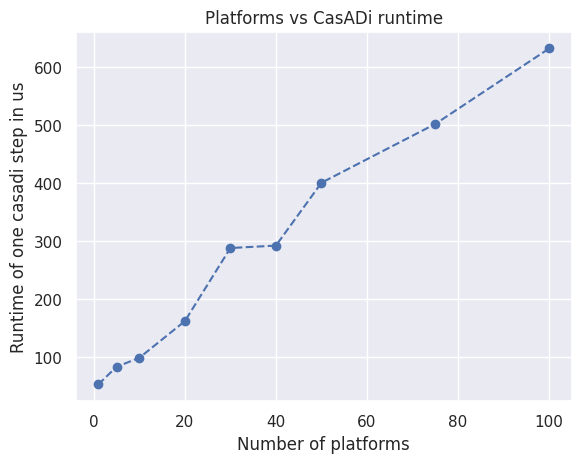

In [18]:
import matplotlib.pyplot as plt
plt.plot(nb_platforms_span, avg_time, 'o--')
plt.ylabel("Runtime of one casadi step in us")
plt.xlabel("Number of platforms")
plt.title("Platforms vs CasADi runtime")